In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import albumentations as A
from sklearn.metrics import precision_score, recall_score, f1_score

import time
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp
import shutil

import tifffile as tiff
import earthpy.plot as ep
from skimage import measure
from skimage import filters

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
image_path = "semantic-drone-dataset/dataset/semantic_drone_dataset/trees_images/"
mask_path = "semantic-drone-dataset/dataset/semantic_drone_dataset/trees_masks_bald_same/"

In [23]:
mask = np.array(Image.open("semantic-drone-dataset/dataset/semantic_drone_dataset/trees_masks_bald_same/001.png").convert("L"))
np.unique(mask)

array([0, 1], dtype=uint8)

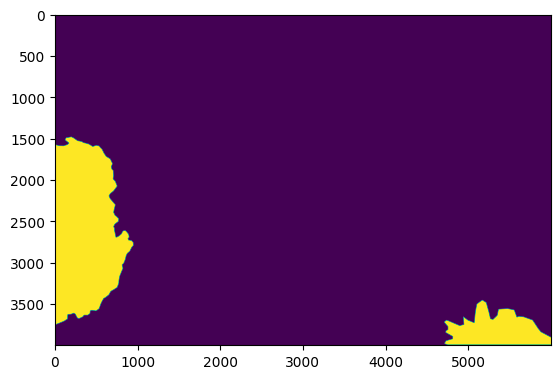

In [24]:
plt.imshow(mask)

# Step 1: Setting Up the Dataset

In [34]:
class TreeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, images_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = images_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx] + '.jpg')
        mask_path = os.path.join(self.mask_dir, self.images[idx] + '.png')  # Adjust the extension if necessary

        image = Image.open(img_path).convert("RGB")
        
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
        else:
            raise FileNotFoundError(f"Mask file not found: {mask_path}")

        if self.transform:
            augmented = self.transform(image=np.array(image), mask=np.array(mask))
            image = augmented['image']
            mask = augmented['mask']

        image = T.ToTensor()(image)
        mask = T.ToTensor()(mask)

        return image, mask
    

# Step 2: Define Transformations

In [26]:
transform = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
], additional_targets={'mask': 'mask'})


# Step 3: Initialize Datasets and Dataloaders

In [35]:
n_classes = 2

def create_df():
    name = []
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  255


In [36]:
# Split the data for training, testing, and validation
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=42)
train_set, val_set = train_test_split(X_trainval, test_size=0.15, random_state=42)

# Create dataset objects
train_dataset = TreeDataset(image_dir=image_path, mask_dir=mask_path, images_list=train_set, transform=transform)
val_dataset = TreeDataset(image_dir=image_path, mask_dir=mask_path, images_list=val_set, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Step 4: Define the Model

In [37]:
model = smp.Unet(
    encoder_name="vgg16",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,               # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                   # model output channels (number of classes in your dataset)
).to(device)

# Step 5: Define Loss and Optimizer

In [ ]:
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

# Step 6: Training and Validation Loops

In [56]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.9930335712432862, Val Loss: 0.9943318247795105


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.9935270977020264, Val Loss: 0.9946302175521851


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.9931458902359008, Val Loss: 0.9940396308898926


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.9930117034912109, Val Loss: 0.9944387197494506


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.9928949189186096, Val Loss: 0.994642686843872


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.9929604697227478, Val Loss: 0.9946921110153198


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.9928045749664307, Val Loss: 0.9946178913116455


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.9929921412467957, Val Loss: 0.9941008448600769


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.9931634068489075, Val Loss: 0.9943957448005676


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.9931978225708008, Val Loss: 0.9942754983901978


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.9929805779457093, Val Loss: 0.9962094068527222


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.9930724835395813, Val Loss: 0.9939864754676819


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.9930589842796326, Val Loss: 0.994140374660492


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.993004891872406, Val Loss: 0.9935811519622803


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.9927021718025207, Val Loss: 0.9935250163078309


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.9925624752044677, Val Loss: 0.9937674045562744


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.992638177871704, Val Loss: 0.9940501928329468


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.9925250720977783, Val Loss: 0.9941450238227845


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.9924974250793457, Val Loss: 0.9939163804054261


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.9925075721740723, Val Loss: 0.9933335900306701


In [57]:
torch.save(model, 'Test3.pt')

In [4]:
transform_prediction = A.Compose([
    A.Resize(256, 256, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [2]:
model123 = torch.load('models/Unet-vgg16-best-fit.pt')

c:\Users\tariq\Desktop\traitement images\Semantic-Segmentation-of-Remote-Sensing-Images-Based-on-FCN-jinwu\venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


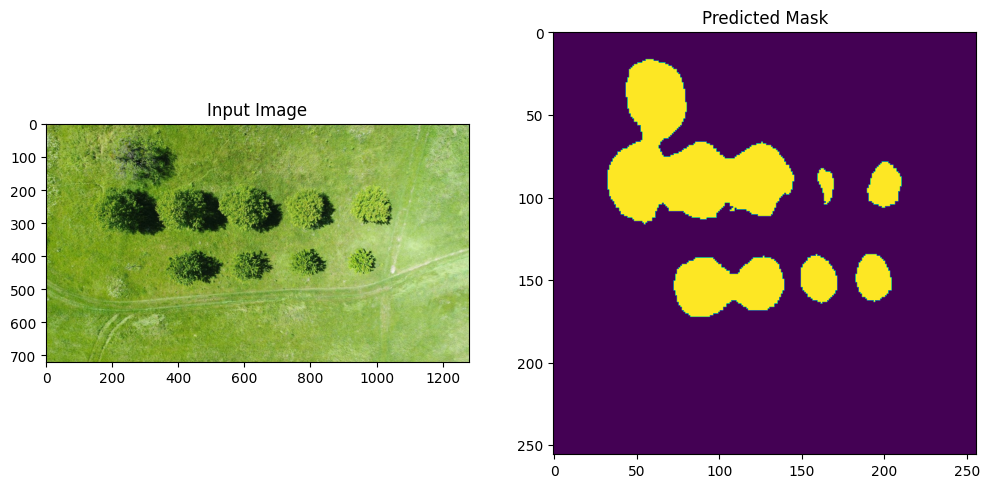

In [5]:

def predict_mask(model, image_path, transform, device):
    model.eval()  # Set the model to evaluation mode

    image = Image.open(image_path).convert("RGB")
    image = np.array(image)
    
    # Apply the same transformations as during training
    augmented = transform(image=image)
    image = augmented['image']
    image = T.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)
        output = (output > 0.5).float()  # Binarize the output
        output = output.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU

    return output

# Example usage
image_path = 'images/a.jpg'
predicted_mask = predict_mask(model123, image_path, transform_prediction, device)

# Plot the input image and the predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path).convert("RGB"))
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title("Predicted Mask")
plt.show()


### The augmentations that we do before training the data

In [77]:
train_transform = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise(),
], additional_targets={'mask': 'mask'})

In [11]:
mask_path = 'semantic-drone-dataset/dataset/semantic_drone_dataset/trees_masks_bald_same/001.png'  # Update this path to your image
image_path = 'semantic-drone-dataset/dataset/semantic_drone_dataset/trees_images/001.jpg'  # Update this path to your mask

### Some application like counting number of trees

Otsu Threshold: 0.39441111808332197


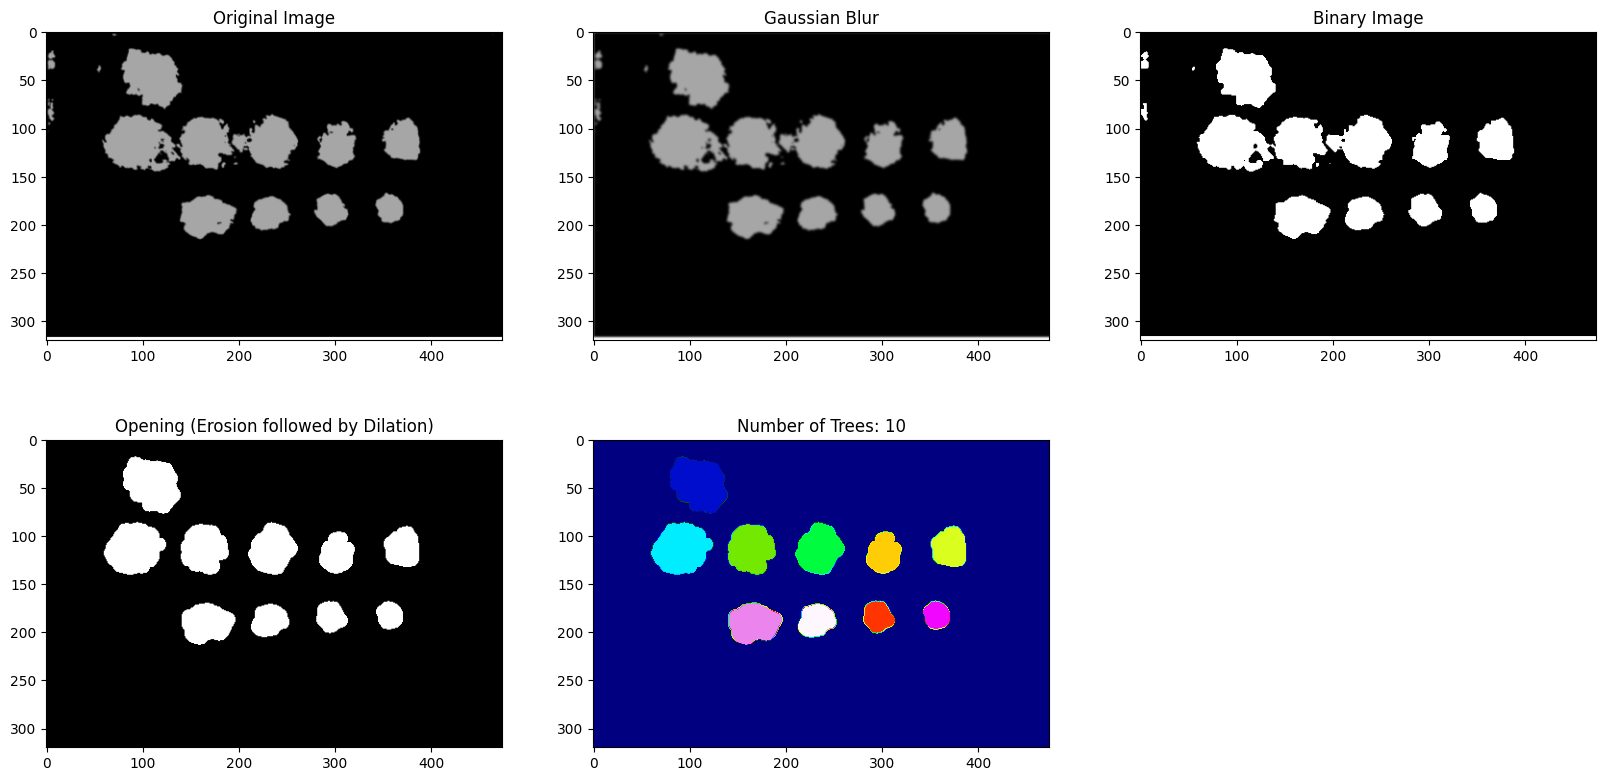

In [80]:
image_pil = Image.open("images/trees_count.PNG").convert("L")

def Opening(image, filter_size):
    img = np.copy(image)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (filter_size, filter_size))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

def Binary(image, threshold, max_value=1):
    img = np.copy(image)
    (t, masklayer) = cv2.threshold(img, threshold, max_value, cv2.THRESH_BINARY)
    return masklayer

def Gaussian_filter(image, sigma=1):
    img = np.copy(image)
    blur = filters.gaussian(img, sigma=sigma)
    return blur

def Find_threshold_otsu(image):
    t = filters.threshold_otsu(image)
    return t

def ExtractObjects(image):
    img = np.copy(image)
    blob_labels = measure.label(img, background=0)
    number_of_objects = np.unique(blob_labels)
    return blob_labels, number_of_objects

def post_processing(img):
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')
    
    # Step 1: Gaussian Blur
    blur = Gaussian_filter(img, sigma=1)
    plt.subplot(3, 3, 2)
    plt.title("Gaussian Blur")
    plt.imshow(blur, cmap='gray')
    
    # Step 2: Find Otsu Threshold
    t = Find_threshold_otsu(blur)
    print(f'Otsu Threshold: {t}')
    
    # Step 3: Binary Image
    binary_img = Binary(blur, t)
    plt.subplot(3, 3, 3)
    plt.title("Binary Image")
    plt.imshow(binary_img, cmap='gray')
    
    # Step 4: Opening
    opened_img = Opening(binary_img, filter_size=15)
    plt.subplot(3, 3, 4)
    plt.title("Opening (Erosion followed by Dilation)")
    plt.imshow(opened_img, cmap='gray')
    
    # Step 5: Extract Objects
    blob_labels, number_of_objects = ExtractObjects(opened_img)
    plt.subplot(3, 3, 5)
    plt.title("Number of Trees: {}".format(number_of_objects[-1]))
    plt.imshow(blob_labels, cmap='gist_ncar')
    
    return opened_img, number_of_objects, blob_labels

# Assuming image_pil is the input PIL image converted to a numpy array

# Call the post_processing function
opened_img, number_of_objects, blob_labels = post_processing(image_pil)

# Show the plot
plt.show()